In [1]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcol
from matplotlib.colors import ListedColormap

from zipfile import ZipFile

In [20]:
date1 = '2024-07-13'
date2 = '2024-07-13'
init_hour = '00'
DATADIR = 'data'
WDIR = f'cams_fc_eaqi_{date1}_{date2}_{init_hour}'
WDIR2 = f'cams_fc_pm_{date1}_{date2}_{init_hour}'

In [21]:
import cdsapi

In [22]:
c = cdsapi.Client()

We use the [CAMS global atmospheric composition forecasts](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview)

In [23]:
# Retrieve variables

c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'variable': [
            'nitrogen_dioxide', 
            'ozone', 
            'particulate_matter_10um',
            'particulate_matter_2.5um', 
            'sulphur_dioxide', 
            'surface_pressure',
            'temperature',
            ],
		'date': f'{date1}/{date2}',
        'time': f'{init_hour}:00',
        'leadtime_hour': [
            '0', '3', '6',
            '9', '12', '15',
            '18', '21', '24',
            '27', '30', '33',
            '36', '39', '42',
            '45', '48', #'51',
        #    '54', '57', '60', 
        #    '63', '66', '69', 
        #    '72', '75', '78', 
        #    '81', '84', '87',
        #    '90', '93', '96',
        #    '99', '102', '105',
        #    '108', '111', '114',
        #    '117', '120',
        ],
        'model_level': '137',
        'type': 'forecast',
        'area': [
            90, -180, -90,
            180,
        ],
        'format': 'netcdf_zip',
    },
    f'{DATADIR}/{WDIR}.zip')

# Create a ZipFile Object and load zip file in it
with ZipFile(f'{DATADIR}/{WDIR}.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path=f'{DATADIR}/{WDIR}/')

2024-07-13 22:05:55,082 INFO Welcome to the CDS
2024-07-13 22:05:55,084 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2024-07-13 22:05:55,184 INFO Request is completed
2024-07-13 22:05:55,185 INFO Downloading https://download-0001-ads-clone.copernicus-climate.eu/cache-compute-0001/cache/data8/adaptor.mars_constrained.internal-1720900331.9235218-23747-9-10299d7e-57e8-4d5b-9289-4caf5419f501.zip to data/cams_fc_eaqi_2024-07-13_2024-07-13_00.zip (92.1M)
2024-07-13 22:06:09,212 INFO Download rate 6.6M/s   


In [40]:
maplon = [-90,-65]
maplat = [35,50]
maplon = [-180,180]
maplat = [-90,90]
region = 'europe'
#maplon = [-25,40]
#maplat = [30,70]
#region = 'southkorea'
#maplon = [115,145]
#maplat = [30,50]

proj_in = ccrs.PlateCarree()
projection = proj_in
#projection = ccrs.TransverseMercator(0)
#projection = ccrs.AlbersEqualArea(central_longitude=0, central_latitude=45)

lllabs = True

lonmin = maplon[0]
lonmax = maplon[1]
latmin = maplat[0]
latmax = maplat[1]

In [41]:
# Open model level data
dsl = xr.open_dataset(f'{DATADIR}/{WDIR}/levtype_ml.nc')
dss = xr.open_dataset(f'{DATADIR}/{WDIR}/levtype_sfc.nc')
#ds = xr.merge([dsl, dss])
#ds = ds.where((ds.latitude < latmax) & (ds.latitude > latmin) & (ds.longitude < lonmax) & (ds.longitude > lonmin),drop=True)

In [42]:
cfactor = dss['sp'] / (287 * dsl['t'])

In [43]:
params1 = ['no2','go3','so2']
for param in params1:
    dsl[param] = dsl[param] * cfactor * 1e9

params2 = ['pm2p5','pm10']
for param in params2:
    dss[param] = dss[param] * 1e9

In [44]:
dsl_max = dsl.resample(time='1D').max()
dsl_max = dsl_max.squeeze(drop=True)

In [45]:
dss_mean = dss.resample(time='1D').mean()
dss_mean = dss_mean.squeeze(drop=True)

In [46]:
eaqi_daily = xr.merge([dsl_max,dss_mean])
eaqi_daily

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, time: 3)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2024-07-13 2024-07-14 2024-07-15
Data variables:
    go3        (time, latitude, longitude) float32 42.88 42.88 ... 50.15 50.15
    so2        (time, latitude, longitude) float32 0.05247 0.05247 ... 0.0 0.0
    t          (time, latitude, longitude) float32 273.9 273.9 ... 215.4 215.4
    no2        (time, latitude, longitude) float32 0.02888 0.02888 ... 0.0 0.0
    pm2p5      (time, latitude, longitude) float32 2.497 2.497 2.497 ... 0.0 0.0
    sp         (time, latitude, longitude) float32 1.007e+05 ... 6.701e+04
    pm10       (time, latitude, longitude) float32 4.913 4.913 4.913 ... 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-13 19:52:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [47]:
eaqi_daily = eaqi_daily.drop_vars(["t", "sp"])
eaqi_daily

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, time: 3)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2024-07-13 2024-07-14 2024-07-15
Data variables:
    go3        (time, latitude, longitude) float32 42.88 42.88 ... 50.15 50.15
    so2        (time, latitude, longitude) float32 0.05247 0.05247 ... 0.0 0.0
    no2        (time, latitude, longitude) float32 0.02888 0.02888 ... 0.0 0.0
    pm2p5      (time, latitude, longitude) float32 2.497 2.497 2.497 ... 0.0 0.0
    pm10       (time, latitude, longitude) float32 4.913 4.913 4.913 ... 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-13 19:52:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [48]:
cmap = ListedColormap(['#5AAA5F', '#A7D25C', '#ECD347', '#F5BE41', '#F09235'])#, '#D93322'])
labels = ['Very good', 'Good', 'Medium', 'Poor', 'Very Poor']#, 'Extremely Poor']
levels1 = [0.5,1.5,2.5,3.5,4.5,5.5]#,6.5]
levels2 = [1,2,3,4,5]#,6]

C:\Users\Luigi\Anaconda3\envs\sklearn-env\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


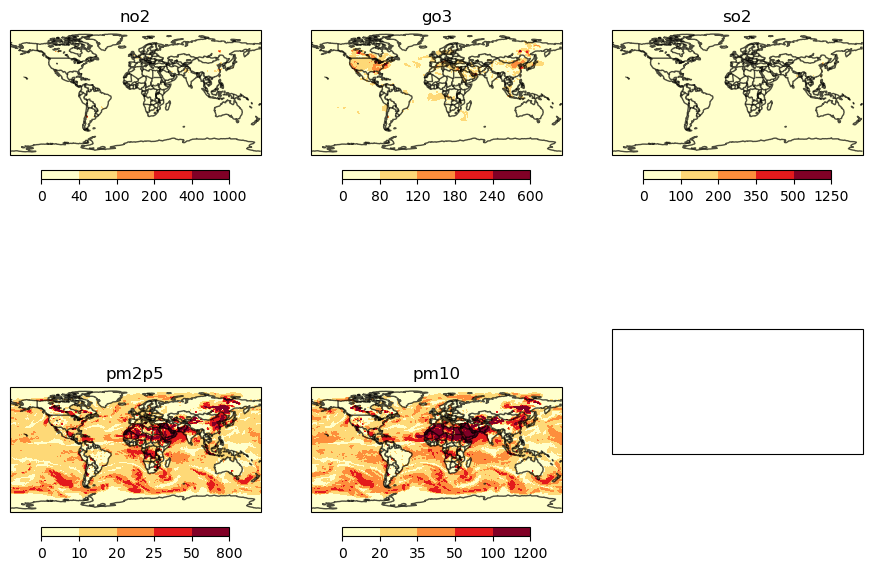

In [49]:
params = ['no2','go3','so2','pm2p5','pm10']
#clevs_p = [[0, 40, 90, 120, 230, 340, 1000],[0, 50, 100, 130, 240, 380, 800],[0, 100, 200, 350, 500, 750, 1250],[0, 20, 40, 50, 100, 150, 1200],[0, 10, 20, 25, 50, 75, 800]]
clevs_p = [
    [0,40,100,200,400,1000],
    [0,80,120,180,240,600],
    [0,100,200,350,500,1250],
    [0,10,20,25,50,800],
    [0,20,35,50,100,1200]
]

nrows=2
ncols=3

fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': projection},
                        figsize=(11,8.5))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

for i,param in enumerate(params):
    # Specify geographical extent
    axs[i].set_extent([lonmin,lonmax,latmin,latmax], crs=ccrs.PlateCarree())
    #
    da = eaqi_daily[param] 
    #
    vmin = da.min()
    vmax_ = da.max()/5
    vdiv = (vmax_ - vmin) / 10
    vmax = vmax_ + vdiv
    #clevs = np.arange(vmin,vmax,vdiv)
    clevs = clevs_p[i]
    #
    axs[i].set_title(param)
    cs = axs[i].contourf(da.longitude, da.latitude, da[2,:,:], levels=clevs, cmap='YlOrRd', norm = mcol.BoundaryNorm(clevs, 256),
                         transform=ccrs.PlateCarree())
    axs[i].coastlines(color='black', alpha=0.7) 
    axs[i].add_feature(cfeature.LAKES, alpha=0.7, edgecolor='black', facecolor='none')
    axs[i].add_feature(cfeature.BORDERS, alpha=0.7)
    #axs[i].add_feature(cfeature.STATES, alpha=0.7)
    #
    cbar = plt.colorbar(cs,fraction=0.046, pad=0.05, orientation='horizontal', shrink=0.75)

In [50]:
#no2_limits = [0, 40, 90, 120, 230, 340, 1000]
#ozone_limits = [0, 50, 100, 130, 240, 380, 800]
#pm10_limits = [0, 10, 20, 25, 50, 75, 800]
#pm25_limits = [0, 20, 40, 50, 100, 150, 1200]
#so2_limits = [0, 100, 200, 350, 500, 750, 1250]
no2_limits = [0,40,100,200,400,1000]
ozone_limits = [0,80,120,180,240,600]
pm10_limits = [0,20,35,50,100,1200]
pm25_limits = [0,10,20,25,50,800]
so2_limits = [0,100,200,350,500,1250]

bin_list = [no2_limits, ozone_limits, pm10_limits, pm25_limits, so2_limits]
variable_list = ['no2', 'go3','pm10', 'pm2p5', 'so2'] #list(eaqi_daily.variables)

In [51]:
classified_arrays = []
for i in range(0,len(bin_list)):
    variable = variable_list[i]
    temp = xr.apply_ufunc(np.digitize,
              eaqi_daily[variable],
              bin_list[i])
    classified_arrays.append(temp)

In [52]:
combined = xr.merge(classified_arrays)

In [37]:
final_index = combined.to_array().max('variable')

In [38]:
cmap = ListedColormap(['#5AAA5F', '#A7D25C', '#ECD347', '#F5BE41', '#F09235'])#, '#D93322'])
labels = ['Very good', 'Good', 'Medium', 'Poor', 'Very Poor']#, 'Extremely Poor']
levels1 = [0.5,1.5,2.5,3.5,4.5,5.5]#,6.5]
levels2 = [1,2,3,4,5]#,6]

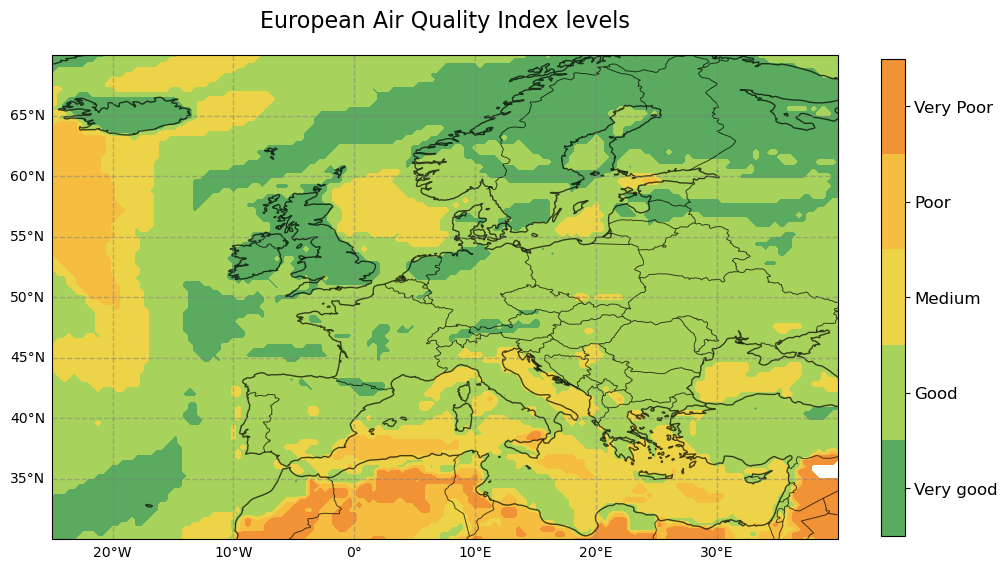

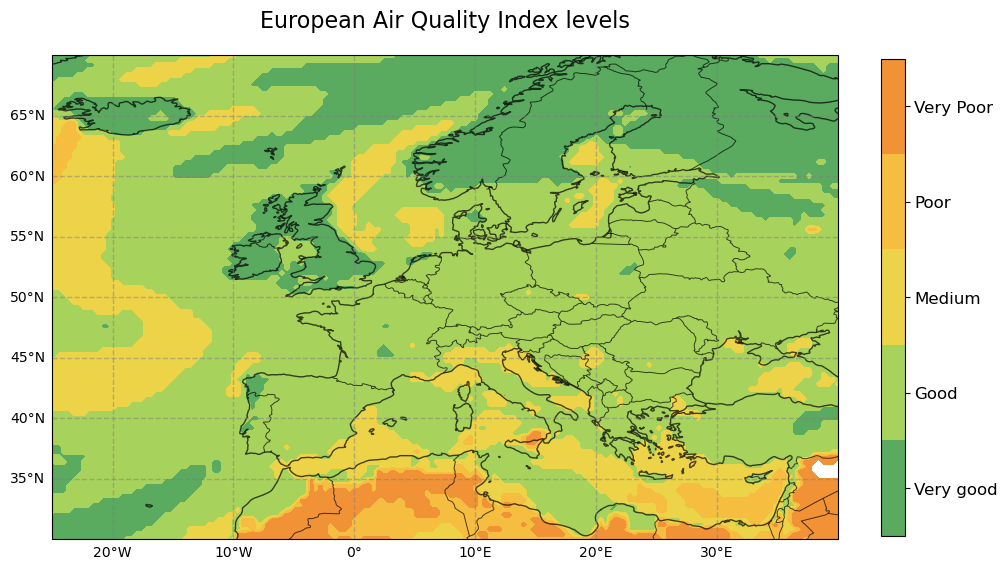

In [39]:
n = final_index.time.shape[0]-1

for i in range(n):
    fig, ax = plt.subplots(1, 1, figsize = (11,8), subplot_kw={'projection': ccrs.PlateCarree()})
    # Specify geographical extent
    #ax.set_extent([lonmin,lonmax,latmin,latmax], crs=ccrs.PlateCarree()) 
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=ccrs.PlateCarree()) 
    gl = ax.gridlines(draw_labels=lllabs, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
    gl.top_labels=False
    gl.right_labels=False
    
    # Set figure title
#    dstr1 = (datetime.strptime(dstr0, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
#    dstr = ' valid for '.join([dstr00,dstr1])
#    ax.set_title('CAMS Regional European Air Quality Index forecast: \n '+dstr, fontsize=12)
    # Plotting function
    img = plt.contourf(final_index.longitude, final_index.latitude, final_index[i,:,:],
                       levels1, vmin=1, vmax=5, cmap=cmap)
    
    # Set the title of the plot
    ax.set_title('European Air Quality Index levels', fontsize=16, pad=20.0)
    
    # Customize colorbar
    cbar = plt.colorbar(img, fraction=0.028, pad=0.05) 
    cbar.set_label(None)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks(levels2)
    cbar.set_ticklabels(labels)
    
    # Add additional features such as coastlines and a geographic grid 
    ax.coastlines(color='black', alpha=0.7, resolution='50m')
    ax.add_feature(cfeature.BORDERS, alpha=0.7, linewidth=0.7)